In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from keras.layers import LSTM, RepeatVector, TimeDistributed, Bidirectional

In [2]:
dataframe = pd.read_csv('output2.csv',usecols=[1]).clip(lower=0).astype('float32')
# dataframe = dataframe.iloc[:12000,:]

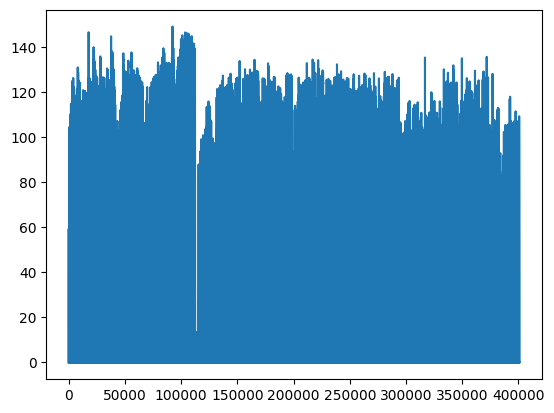

In [3]:
plt.plot(dataframe)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataframe)

In [5]:
dataset.shape

(401000, 1)

In [6]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
test.shape

(80200, 1)

In [7]:
train.shape

(320800, 1)

In [8]:
def to_sequences(dataset, time_window,output):
    x = []
    y = []

    for i in range(len(dataset)-time_window-1-output):
        #print(i)
        window = dataset[i:(i+time_window), 0]
        x.append(window)
        y.append(dataset[i+time_window:i+time_window+output, 0])

    return  np.array(x), np.array(y)

In [9]:
time_window = 10
output=20 # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, time_window, output)
testX, testY = to_sequences(test, time_window,output)

In [10]:
trainY.shape

(320769, 20)

In [11]:
trainX = trainX.reshape(trainX.shape[0],trainX.shape[1],1)
testX = testX.reshape(testX.shape[0],testX.shape[1],1)

In [12]:
import keras
from keras import layers
import tensorflow as tf

In [13]:
def lstm_attention_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # LSTM layer
    lstm = layers.LSTM(100, activation="relu",return_sequences=True)(inputs)
    
    # Attention mechanism
    attention = layers.Dense(1, activation='relu')(lstm)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(100)(attention)
    attention = layers.Permute([2, 1])(attention)
    attention = layers.Multiply()([lstm, attention])
    attention = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)
    
    # Output layer
    outputs = layers.Dense(output)(attention)
    # outputs = layers.LeakyReLU(0.2)(outputs)
    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [14]:
model2=lstm_attention_model(input_shape=(10,1))

In [15]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 10, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 10, 100)           │          40,800 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 10, 1)             │             101 │ lstm[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 10)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 10)                │               0 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector (RepeatVector)  │ (None, 100, 10)           │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ permute (Permute)             │ (None, 10, 100)           │               0 │ repeat_vector[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 10, 100)           │               0 │ lstm[0][0], permute[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda (Lambda)               │ (None, 100)               │               0 │ multiply[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 20)                │           2,020 │ lambda[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 42,921 (167.66 KB)

 Trainable params: 42,921 (167.66 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model2.fit(trainX, trainY, batch_size=32 , validation_data=(testX, testY),epochs=20)

Epoch 1/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0149 - val_loss: 0.0074
Epoch 2/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.0083 - val_loss: 0.0070
Epoch 3/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 4/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 5/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 6/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 7/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 8/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 9/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 10/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 11/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.0066 - val_loss: 0.00

In [17]:
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

10025/10025 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [18]:
trainPredict.shape

(320769, 20)

In [19]:
trainY.shape

(320769, 20)

In [20]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY= scaler.inverse_transform(trainY)
testY= scaler.inverse_transform(testY)

In [21]:
from sklearn.metrics import  mean_squared_error as mse
import math

In [22]:
train_RMSE = math.sqrt(mse(trainPredict,trainY))
test_RMSE = math.sqrt(mse(testPredict,testY))

In [23]:
train_RMSE

11.779513688986631

In [24]:
test_RMSE

10.964139572596785

In [34]:
trainPredict[:10]

array([[32.069893, 33.049004, 33.371048, 34.071594, 34.91652 , 36.167248,
        37.26096 , 38.187164, 38.498688, 39.440292, 40.37851 , 41.135796,
        42.093945, 42.946217, 43.18656 , 44.39231 , 44.51736 , 45.65736 ,
        45.971016, 46.010914],
       [39.092766, 41.40087 , 43.65356 , 45.860485, 48.10038 , 50.42348 ,
        52.65236 , 54.247234, 55.66103 , 57.879223, 59.70808 , 61.72963 ,
        63.674988, 65.781975, 67.38692 , 69.22411 , 70.01432 , 71.82707 ,
        73.16682 , 73.79891 ],
       [47.772717, 50.378788, 53.10357 , 55.05629 , 57.715168, 59.97448 ,
        61.445206, 63.57112 , 65.16399 , 67.62801 , 69.53308 , 72.17028 ,
        74.42233 , 77.043915, 79.19229 , 80.766754, 81.64606 , 83.11494 ,
        85.25675 , 86.11178 ],
       [45.635826, 47.075672, 49.039158, 50.302685, 52.52668 , 54.299217,
        55.262287, 57.24025 , 58.649216, 60.70524 , 62.415882, 64.90809 ,
        66.99948 , 69.326904, 71.29425 , 72.3589  , 73.11095 , 74.06258 ,
        76.01783 , 

In [33]:
trainY[:10]

array([[35.73    , 40.791996, 42.312   , 46.647   , 49.429   , 52.68    ,
        56.724   , 55.462006, 55.672   , 54.540005, 52.421   , 51.208   ,
        50.691   , 51.483   , 52.987995, 52.567   , 53.829   , 55.543   ,
        54.524   , 56.077   ],
       [40.791996, 42.312   , 46.647   , 49.429   , 52.68    , 56.724   ,
        55.462006, 55.672   , 54.540005, 52.421   , 51.208   , 50.691   ,
        51.483   , 52.987995, 52.567   , 53.829   , 55.543   , 54.524   ,
        56.077   , 57.71    ],
       [42.312   , 46.647   , 49.429   , 52.68    , 56.724   , 55.462006,
        55.672   , 54.540005, 52.421   , 51.208   , 50.691   , 51.483   ,
        52.987995, 52.567   , 53.829   , 55.543   , 54.524   , 56.077   ,
        57.71    , 57.84    ],
       [46.647   , 49.429   , 52.68    , 56.724   , 55.462006, 55.672   ,
        54.540005, 52.421   , 51.208   , 50.691   , 51.483   , 52.987995,
        52.567   , 53.829   , 55.543   , 54.524   , 56.077   , 57.71    ,
        57.84    , 

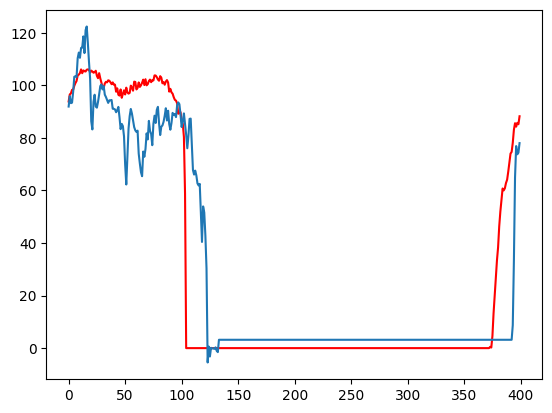

In [32]:
plt.plot(testY[400:800,19], color='r')
plt.plot(testPredict[400:800,19])

In [28]:
x_test = np.array([0.067932,0.23938,3.3028,5.7289,13.299,19.154,23.278,29.618,32.772,34.746])
x_test = x_test.reshape((-1, 10,1))
print(x_test.shape)

(1, 10, 1)


In [29]:
yhat = model2.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [30]:
yhat

array([[34.38175 , 42.064816, 43.222767, 46.84898 , 47.560802, 49.41401 ,
        51.218422, 51.198185, 51.284996, 52.611034, 54.008595, 54.01367 ,
        58.32544 , 63.96942 , 67.01068 , 68.26464 , 66.815   , 69.19427 ,
        71.969025, 68.78907 ]], dtype=float32)